# Notebook for Analysis of Lactose Dehydrogenase Assay

This notebook analyzes raw data from the lactose dehydrogenase (LDH) assay. This enzyme activity assay measures LDH levels in cell culture supernatant. LDH is a constitutively expressed cytosolic enzyme necessary for anaerobic respiration. It performs reversible conversion of lactate to pyruvate, resulting in the production of one equivalent of NADH, the molecule detected by this assay. Typically, LDH is only released into the culture supernatant during loss of cell membrane integrity (i.e., due to cell death).

### Inputs
The input data for this notebook are a raw data file (`data_filename`) from a plate reader and a sample manifest (`manifest_filename`), which is filled out by the experimenter for each experiment. Other parameters defined by the user include: the names of the assay controls (`standard_columns` and `background`) from the sample manifest; the total sample volume in each well (`V`); and the name of the experiment (`experiment_id`), which is used for plot labels. After initial processing of the raw data, the user can select two time points (`t1` and `t2`) in the linear response range that are used to determine the LDH enzyme level in each analyte sample.

### Outputs
The notebook parses the input data file into metadata and well-by-well time-series data and uses the sample manifest to generate labeled and background-subtracted data, which are saved as csvs. For each time point, standard curve plots are generated and saved as png files. For each analyte sample, the notebook plots absorbance values over time and saves these as png files. Next, the notebook performs quadratic curve fits to the standard curves at each user-defined time point and uses these to determine NADH levels at each time point and LDH levels for each analyte. These results are exported as a csv.  Finally, the notebook performs statistical analysis and generates one-way ANOVA results and Tukey HSD comparisons. The latter is saved as a csv file.

In [25]:
import os
import re

from collections import defaultdict
import arcadia_pycolor as apc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import f_oneway
from sklearn.metrics import r2_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# Parameterization

data_filename = "../data_files/20250204_ldh_assay.csv"  # enter raw data file name here
manifest_filename = "../data_files/20250204_ldh_manifest.csv"  # enter sample manifest file name here

background = "0"  # enter the data label for the background samples
standard_columns = [
    "250",
    "200",
    "150",
    "100",
    "50",
]  # enter the standard column values as a list of strings

V = 0.05  # Total sample volume in mL, should be 0.05 unless the protocol is altered
experiment_id = "20250204 48/80 Dose Response Assay in HMC1.2"  # For final data plot label

In [3]:
if os.path.exists(data_filename):
    data = pd.read_csv(data_filename)
    print(f"File '{data_filename}' loaded successfully.")
else:
    print(f"Error: File '{data_filename}' not found in the directory '{directory}'.")
    print(
        """
        Please check the file path, file name, and ensure the file is present
        at the specified location.
        """
    )

File '../data_files/20250204_ldh_assay.csv' loaded successfully.


In [5]:
# Metadata are found in rows where both column A and column B have non-empty values,
# so metadata are extracted by identifying rows with non-empty values in these columns.

output_directory = os.path.splitext(os.path.basename(data_filename))[0]
output_path = '../output_files/' + output_directory
os.makedirs(output_path, exist_ok = True)

output_filename = output_path + '/' + output_directory

metadata = data.dropna(subset=["User", "Public"])
metadata = metadata.iloc[:, :2]
metadata.to_csv(output_filename + "_metadata.csv", index=False)
metadata

,User,Public
0,Protocol name,New ABS Protocol
1,Time of export,02/05/2025 00:00:16
2,Time of last change,02/04/2025 23:29:22
3,Time of last use (end time),02/05/2025 00:00:03
4,Software version,1.2.0.0
5,Instrument name,iD3-2585
6,Serial number,2585
10,Experiment name,Experiment 1
13,Plate name,Plate 1
15,Microplate name,Standard clrbtm


In [6]:
# Samples are laid out in columns defined by the well position in a 96-well plate,
# each row corresponds to a time-point.
# Look for a row where columns contain values A1, A2, ..., H11, H12.

pattern = r"^[A-H][1-9]$|^[A-H]1[0-2]$"


def find_header_index(data, pattern):
    """
    Find the row index of the defined pattern of well labels that
    identifies the location of the sample data.

    Args:
        data: The raw dataframe exported from the plate reader and imported into pandas
        pattern: The regular expression that defines the well headers (typically A1 - H12)

    Returns:
        int: The row index of the well headers
    """
    for idx, row in data.iterrows():
        non_nan_values = row[2:].dropna()
        if (
            len(non_nan_values) > 0
            and sum(bool(re.match(pattern, str(val))) for val in non_nan_values)
            >= len(non_nan_values) / 2
        ):
            return idx
    raise ValueError("No valid header row found. Please check the data structure.")


# Header row index should be found by find_header_index.
# The header_index printout can be used to verify that this is done correctly.
# Check that the raw csv file is appropriately structured if issues are encountered.
header_index = find_header_index(data, pattern)
print(header_index)

sample_data = data.iloc[header_index + 1 :, 2:].dropna(how="all")
sample_data = sample_data.reset_index(drop=True)

# The first column is 'Cycle (seconds)', defining it as the time column,
# and remaining columns are well positions (A1 - H12).
column_names = ["Cycle (seconds)"] + [
    col for col in data.iloc[header_index, 2:] if re.match(pattern, str(col))
]
sample_data.columns = column_names

sample_data.to_csv(output_filename + "_sample_data.csv", index=False)
sample_data

50


,Cycle (seconds),A1,A2,A3,A4,A5,A6,A7,A8,A9,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,0,0.784,0.412,0.22,0.197,0.189,0.195,0.214,0.198,0.172,...,0.624,0.416,0.233,0.062,0.033,0.033,0.033,0.033,0.034,0.034
1,120,1.602,0.919,0.467,0.402,0.38,0.4,0.439,0.405,0.339,...,0.652,0.437,0.243,0.059,0.033,0.033,0.033,0.033,0.034,0.034
2,239.89,2.231,1.394,0.706,0.602,0.57,0.599,0.662,0.605,0.503,...,0.658,0.444,0.246,0.059,0.033,0.033,0.033,0.033,0.034,0.034
3,359.82,2.384,1.838,0.942,0.796,0.756,0.795,0.877,0.801,0.664,...,0.661,0.448,0.246,0.06,0.033,0.033,0.033,0.033,0.034,0.034
4,479.97,2.354,2.248,1.169,0.988,0.938,0.984,1.086,0.991,0.82,...,0.664,0.448,0.247,0.059,0.033,0.033,0.033,0.033,0.034,0.034
5,599.89,2.336,2.618,1.387,1.169,1.113,1.17,1.287,1.174,0.973,...,0.662,0.446,0.247,0.059,0.033,0.033,0.033,0.033,0.034,0.034
6,719.8,2.33,2.944,1.598,1.349,1.285,1.347,1.481,1.351,1.12,...,0.663,0.448,0.247,0.06,0.033,0.033,0.033,0.033,0.034,0.034
7,839.88,2.315,3.214,1.801,1.519,1.45,1.52,1.669,1.524,1.265,...,0.658,0.447,0.246,0.061,0.033,0.033,0.033,0.033,0.034,0.034
8,959.81,2.327,3.419,1.994,1.689,1.612,1.685,1.848,1.69,1.405,...,0.664,0.445,0.248,0.061,0.033,0.033,0.033,0.033,0.034,0.034
9,1079.97,2.317,3.555,2.181,1.85,1.767,1.848,2.023,1.85,1.543,...,0.662,0.448,0.246,0.062,0.033,0.033,0.033,0.033,0.034,0.034


In [7]:
# Data must be restructured and labeled for plotting and analysis,
# so sample manifest is used to sort and label data.

if os.path.exists(manifest_filename):
    manifest = pd.read_csv(manifest_filename)
    print(f"File '{manifest_filename}' loaded successfully.")
else:
    print(f"Error: File '{manifest_filename}' not found in the directory '{directory}'.")
    print(
        """
        Please check the file path, file name, and ensure the file is present
        at the specified location.
        """
    )

manifest

File '../data_files/20250204_ldh_manifest.csv' loaded successfully.


,Manifest,1,2,3,4,5,6,7,8,9,10,11,12
0,A,"60.6 µg/mL, 1x dilution","20.2 µg/mL, 1x dilution","6.73 µg/mL, 1x dilution","2.24 µg/mL, 1x dilution","748 ng/mL, 1x dilution","249 ng/mL, 1x dilution","83.1 ng/mL, 1x dilution","27.7 ng/mL, 1x dilution","9.24 ng/mL, 1x dilution","Lysed, 1x dilution","PBS, 1x dilution",NaN
1,B,"60.6 µg/mL, 1x dilution","20.2 µg/mL, 1x dilution","6.73 µg/mL, 1x dilution","2.24 µg/mL, 1x dilution","748 ng/mL, 1x dilution","249 ng/mL, 1x dilution","83.1 ng/mL, 1x dilution","27.7 ng/mL, 1x dilution","9.24 ng/mL, 1x dilution","Lysed, 1x dilution","PBS, 1x dilution",NaN
2,C,"60.6 µg/mL, 1x dilution","20.2 µg/mL, 1x dilution","6.73 µg/mL, 1x dilution","2.24 µg/mL, 1x dilution","748 ng/mL, 1x dilution","249 ng/mL, 1x dilution","83.1 ng/mL, 1x dilution","27.7 ng/mL, 1x dilution","9.24 ng/mL, 1x dilution","Lysed, 1x dilution","PBS, 1x dilution",NaN
3,D,"60.6 µg/mL, 5x dilution","20.2 µg/mL, 5x dilution","6.73 µg/mL, 5x dilution","2.24 µg/mL, 5x dilution","748 ng/mL, 5x dilution","249 ng/mL, 5x dilution","83.1 ng/mL, 5x dilution","27.7 ng/mL, 5x dilution","9.24 ng/mL, 5x dilution","Lysed, 5x dilution",NaN,NaN
4,E,"60.6 µg/mL, 5x dilution","20.2 µg/mL, 5x dilution","6.73 µg/mL, 5x dilution","2.24 µg/mL, 5x dilution","748 ng/mL, 5x dilution","249 ng/mL, 5x dilution","83.1 ng/mL, 5x dilution","27.7 ng/mL, 5x dilution","9.24 ng/mL, 5x dilution","Lysed, 5x dilution",NaN,NaN
5,F,"60.6 µg/mL, 5x dilution","20.2 µg/mL, 5x dilution","6.73 µg/mL, 5x dilution","2.24 µg/mL, 5x dilution","748 ng/mL, 5x dilution","249 ng/mL, 5x dilution","83.1 ng/mL, 5x dilution","27.7 ng/mL, 5x dilution","9.24 ng/mL, 5x dilution","Lysed, 5x dilution",NaN,NaN
6,G,250,200,150,100,50,0,NaN,NaN,NaN,NaN,NaN,NaN
7,H,250,200,150,100,50,0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# A dictionary relating each well position to the corresponding sample name
# will be used to label the raw data.
manifest_dict = {}

for _index, row in manifest.iterrows():
    row_label = row["Manifest"]
    for col_label, value in row.items():
        if col_label != "Manifest" and pd.notna(value):
            well_position = f"{row_label}{col_label}"
            manifest_dict[well_position] = value

# Retain only columns that exist in the manifest_dict keys or are 'Cycle (seconds)'
columns_to_keep = [
    col for col in sample_data.columns if col in manifest_dict or col == "Cycle (seconds)"
]
sample_data_labeled = sample_data[columns_to_keep]

# Rename columns based on the manifest_dict values
sample_data_labeled = sample_data_labeled.rename(columns=manifest_dict)

# Clean-up steps are included to make sure that elements in
# sample_data_labeled are of appropriate types.
# All cell values are floats or NaN, all column header values are strings.
sample_data_labeled = sample_data_labeled.replace("#SAT", np.nan)
sample_data_labeled.columns = sample_data_labeled.columns.map(
    lambda x: str(int(x)) if isinstance(x, float) and x.is_integer() else str(x)
)

sample_data_labeled.to_csv(output_filename + "_sample_data_labeled.csv", index=False)
sample_data_labeled

,Cycle (seconds),"60.6 µg/mL, 1x dilution","20.2 µg/mL, 1x dilution","6.73 µg/mL, 1x dilution","2.24 µg/mL, 1x dilution","748 ng/mL, 1x dilution","249 ng/mL, 1x dilution","83.1 ng/mL, 1x dilution","27.7 ng/mL, 1x dilution","9.24 ng/mL, 1x dilution",...,150,100,50,0,250,200,150,100,50,0
0,0,0.784,0.412,0.22,0.197,0.189,0.195,0.214,0.198,0.172,...,0.596,0.43,0.247,0.056,0.983,0.786,0.624,0.416,0.233,0.062
1,120,1.602,0.919,0.467,0.402,0.38,0.4,0.439,0.405,0.339,...,0.627,0.44,0.247,0.056,1.038,0.829,0.652,0.437,0.243,0.059
2,239.89,2.231,1.394,0.706,0.602,0.57,0.599,0.662,0.605,0.503,...,0.632,0.443,0.248,0.058,1.055,0.845,0.658,0.444,0.246,0.059
3,359.82,2.384,1.838,0.942,0.796,0.756,0.795,0.877,0.801,0.664,...,0.64,0.447,0.249,0.055,1.082,0.856,0.661,0.448,0.246,0.06
4,479.97,2.354,2.248,1.169,0.988,0.938,0.984,1.086,0.991,0.82,...,0.644,0.451,0.25,0.057,1.101,0.854,0.664,0.448,0.247,0.059
5,599.89,2.336,2.618,1.387,1.169,1.113,1.17,1.287,1.174,0.973,...,0.647,0.451,0.25,0.056,1.105,0.858,0.662,0.446,0.247,0.059
6,719.8,2.33,2.944,1.598,1.349,1.285,1.347,1.481,1.351,1.12,...,0.646,0.452,0.251,0.058,1.105,0.858,0.663,0.448,0.247,0.06
7,839.88,2.315,3.214,1.801,1.519,1.45,1.52,1.669,1.524,1.265,...,0.644,0.452,0.252,0.058,1.104,0.86,0.658,0.447,0.246,0.061
8,959.81,2.327,3.419,1.994,1.689,1.612,1.685,1.848,1.69,1.405,...,0.643,0.452,0.25,0.058,1.104,0.858,0.664,0.445,0.248,0.061
9,1079.97,2.317,3.555,2.181,1.85,1.767,1.848,2.023,1.85,1.543,...,0.642,0.45,0.248,0.059,1.105,0.859,0.662,0.448,0.246,0.062


In [10]:
# Background signal should be subtracted from all samples.
# Background signal is calculated separately at each time point
# to control for any time-dependent changes in the background signal.
# Check the blank_means printout to see whether the background signal
# changes significantly over time.


def generate_row_means(df):
    """
    Calculate the mean of each row in a dataframe.

    Args:
        df: A pandas dataframe.

    Returns:
        list[float]: A list of mean values of each row in the input dataframe.
    """
    df = df.apply(pd.to_numeric, errors="coerce")

    means = []

    for _, row in df.iterrows():
        row_mean = row.mean(skipna=True)
        means.append(float(row_mean))

    return means


filtered_data = sample_data_labeled[background]
filtered_data = filtered_data.apply(pd.to_numeric, errors="coerce")

blank_means = generate_row_means(filtered_data)
print(blank_means)

[0.059, 0.057499999999999996, 0.058499999999999996, 0.057499999999999996, 0.057999999999999996, 0.057499999999999996, 0.059, 0.0595, 0.0595, 0.0605, 0.059, 0.06, 0.06, 0.06, 0.0605, 0.06]


In [11]:
def subtract_row_means(data, means):
    """
    Subtracts each value in a list of background means
    from the corresponding time row in the DataFrame.

    Args:
        data: A pandas dataframe containing labeled raw data.
        means: A list of floats containing the mean background signal at each time point.

    Returns:
        pd.Dataframe: Labeled background-subtracted data, with background columns dropped.
    """
    data_numeric = data.apply(pd.to_numeric, errors="coerce")

    if len(data_numeric) != len(means):
        raise ValueError("Length of means list must match the number of rows in the DataFrame.")

    data_subtracted = data_numeric.apply(lambda row: row - means[row.name], axis=1)

    return data_subtracted


sample_data_labeled_nb = subtract_row_means(
    sample_data_labeled, blank_means
)
sample_data_labeled_nb = sample_data_labeled_nb.drop(columns=background)
sample_data_labeled_nb.to_csv(
    output_filename + "_sample_data_labeled_nb.csv", index=False
)
sample_data_labeled_nb

,Cycle (seconds),"60.6 µg/mL, 1x dilution","20.2 µg/mL, 1x dilution","6.73 µg/mL, 1x dilution","2.24 µg/mL, 1x dilution","748 ng/mL, 1x dilution","249 ng/mL, 1x dilution","83.1 ng/mL, 1x dilution","27.7 ng/mL, 1x dilution","9.24 ng/mL, 1x dilution",...,250,200,150,100,50,250,200,150,100,50
0,-0.0590,0.7250,0.3530,0.1610,0.1380,0.1300,0.1360,0.1550,0.1390,0.1130,...,0.9320,0.7420,0.5370,0.3710,0.1880,0.9240,0.7270,0.5650,0.3570,0.1740
1,119.9425,1.5445,0.8615,0.4095,0.3445,0.3225,0.3425,0.3815,0.3475,0.2815,...,0.9565,0.7715,0.5695,0.3825,0.1895,0.9805,0.7715,0.5945,0.3795,0.1855
2,239.8315,2.1725,1.3355,0.6475,0.5435,0.5115,0.5405,0.6035,0.5465,0.4445,...,0.9815,0.7775,0.5735,0.3845,0.1895,0.9965,0.7865,0.5995,0.3855,0.1875
3,359.7625,2.3265,1.7805,0.8845,0.7385,0.6985,0.7375,0.8195,0.7435,0.6065,...,0.9985,0.7865,0.5825,0.3895,0.1915,1.0245,0.7985,0.6035,0.3905,0.1885
4,479.9120,2.2960,2.1900,1.1110,0.9300,0.8800,0.9260,1.0280,0.9330,0.7620,...,1.0220,0.7860,0.5860,0.3930,0.1920,1.0430,0.7960,0.6060,0.3900,0.1890
5,599.8325,2.2785,2.5605,1.3295,1.1115,1.0555,1.1125,1.2295,1.1165,0.9155,...,1.0275,0.7865,0.5895,0.3935,0.1925,1.0475,0.8005,0.6045,0.3885,0.1895
6,719.7410,2.2710,2.8850,1.5390,1.2900,1.2260,1.2880,1.4220,1.2920,1.0610,...,1.0240,0.7870,0.5870,0.3930,0.1920,1.0460,0.7990,0.6040,0.3890,0.1880
7,839.8205,2.2555,3.1545,1.7415,1.4595,1.3905,1.4605,1.6095,1.4645,1.2055,...,1.0265,0.7885,0.5845,0.3925,0.1925,1.0445,0.8005,0.5985,0.3875,0.1865
8,959.7505,2.2675,3.3595,1.9345,1.6295,1.5525,1.6255,1.7885,1.6305,1.3455,...,1.0235,0.7875,0.5835,0.3925,0.1905,1.0445,0.7985,0.6045,0.3855,0.1885
9,1079.9095,2.2565,3.4945,2.1205,1.7895,1.7065,1.7875,1.9625,1.7895,1.4825,...,1.0225,0.7865,0.5815,0.3895,0.1875,1.0445,0.7985,0.6015,0.3875,0.1855


In [12]:
# Technical replicates should be collapsed into single columns to facilitate plotting.
# Each column will have a unique sample name. Technical replicates will be plotted in different rows
# that have the same time value in the time column.

unique_columns = list(dict.fromkeys(sample_data_labeled_nb.columns))

sample_data_collapsed = pd.DataFrame(columns=unique_columns)


def populate_collapsed_df(old_df, new_df):
    """
    Populates a new collapsed dataframe with values the well-by-well dataframe.

    Each treatment group in the collapsed dataframe is represented as a single
    column. Technical replicate values in these columns have the same time value
    in the time column.

    Arguments:
        old_df: The original DataFrame with labeled samples and timepoints.
        new_df:
            The collapsed DataFrame, with each unique sample as a column header,
            to be populated.

    Returns:
        pd.Dataframe:
            The collapsed dataframe, populated with absorbance values from old_df.
    """
    for _index, row in old_df.iterrows():
        cycle_time = row.iloc[old_df.columns.get_loc("Cycle (seconds)")]

        for col_idx in range(len(old_df.columns)):
            col_name = old_df.columns[col_idx]

            if col_name == "Cycle (seconds)":
                continue

            value = row.iloc[col_idx]
            if pd.isna(value):
                continue

            available_row_idx = new_df[
                (new_df["Cycle (seconds)"] == cycle_time) & pd.isna(new_df[col_name])
            ].index.min()

            if not pd.isna(available_row_idx):
                new_df.at[available_row_idx, col_name] = value
            else:
                new_row = {col_name: np.nan for col_name in new_df.columns}
                new_row["Cycle (seconds)"] = cycle_time
                new_row[col_name] = value
                new_df = pd.concat([new_df, pd.DataFrame([new_row])], ignore_index=True)

    new_df.fillna(np.nan, inplace=True)

    return new_df


sample_data_collapsed = populate_collapsed_df(sample_data_labeled_nb, sample_data_collapsed)
sample_data_collapsed.to_csv(output_filename + "_collapsed.csv", index=False)
sample_data_collapsed

/var/folders/f0/d5_1_5d11vl9ywq_z1j0nnk40000gn/T/ipykernel_18694/1294355473.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([new_row])], ignore_index=True)


,Cycle (seconds),"60.6 µg/mL, 1x dilution","20.2 µg/mL, 1x dilution","6.73 µg/mL, 1x dilution","2.24 µg/mL, 1x dilution","748 ng/mL, 1x dilution","249 ng/mL, 1x dilution","83.1 ng/mL, 1x dilution","27.7 ng/mL, 1x dilution","9.24 ng/mL, 1x dilution",...,"249 ng/mL, 5x dilution","83.1 ng/mL, 5x dilution","27.7 ng/mL, 5x dilution","9.24 ng/mL, 5x dilution","Lysed, 5x dilution",250,200,150,100,50
0,-0.0590,0.7250,0.3530,0.1610,0.1380,0.1300,0.1360,0.1550,0.1390,0.1130,...,0.0180,0.0240,0.0210,0.0110,0.0710,0.9320,0.7420,0.5370,0.3710,0.1880
1,-0.0590,1.2340,0.3300,0.1480,0.1190,0.1180,0.1220,0.1350,0.1280,0.0970,...,0.0140,0.0170,0.0200,0.0230,0.0680,0.9240,0.7270,0.5650,0.3570,0.1740
2,-0.0590,1.1600,0.2900,0.1360,0.1090,0.1010,0.1150,0.1250,0.1150,0.0880,...,0.0150,0.0170,0.0160,0.0080,0.0600,NaN,NaN,NaN,NaN,NaN
3,119.9425,1.5445,0.8615,0.4095,0.3445,0.3225,0.3425,0.3815,0.3475,0.2815,...,0.0665,0.0785,0.0735,0.0475,0.2015,0.9565,0.7715,0.5695,0.3825,0.1895
4,119.9425,2.7865,0.8205,0.3975,0.3195,0.3135,0.3285,0.3685,0.3445,0.2615,...,0.0615,0.0725,0.0695,0.0545,0.2005,0.9805,0.7715,0.5945,0.3795,0.1855
5,119.9425,2.7205,0.7855,0.3805,0.3115,0.2925,0.3215,0.3505,0.3275,0.2505,...,0.0655,0.0725,0.0735,0.0485,0.2045,NaN,NaN,NaN,NaN,NaN
6,239.8315,2.1725,1.3355,0.6475,0.5435,0.5115,0.5405,0.6035,0.5465,0.4445,...,0.1125,0.1295,0.1215,0.0845,0.3325,0.9815,0.7775,0.5735,0.3845,0.1895
7,239.8315,3.5905,1.2885,0.6335,0.5175,0.5045,0.5275,0.5895,0.5515,0.4245,...,0.1085,0.1255,0.1195,0.0915,0.3345,0.9965,0.7865,0.5995,0.3855,0.1875
8,239.8315,3.5845,1.2515,0.6145,0.5065,0.4805,0.5245,0.5725,0.5365,0.4125,...,0.1125,0.1245,0.1265,0.0885,0.3475,NaN,NaN,NaN,NaN,NaN
9,359.7625,2.3265,1.7805,0.8845,0.7385,0.6985,0.7375,0.8195,0.7435,0.6065,...,0.1615,0.1825,0.1715,0.1235,0.4635,0.9985,0.7865,0.5825,0.3895,0.1915


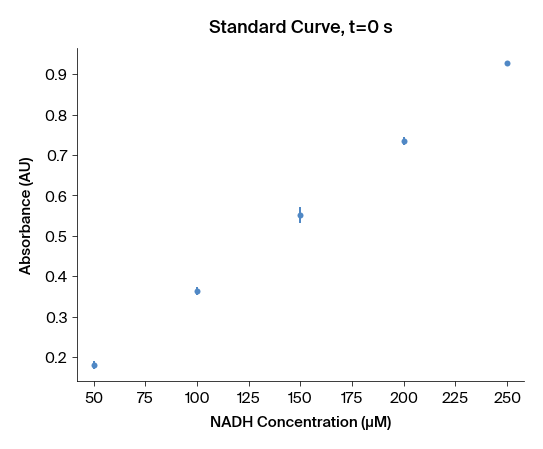

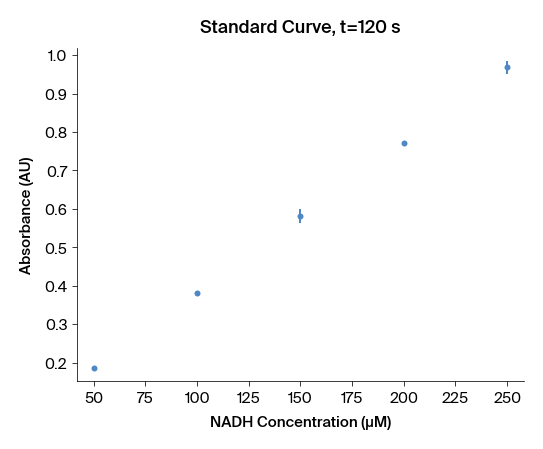

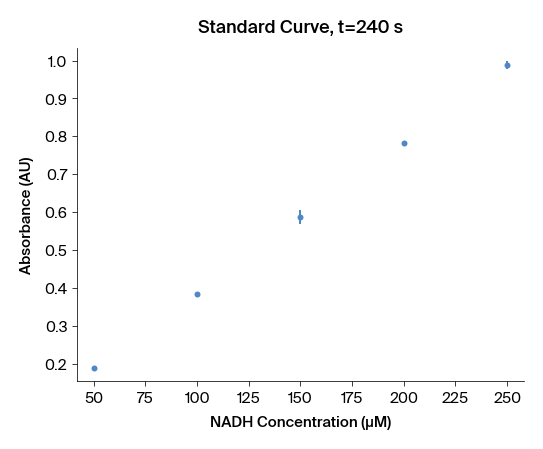

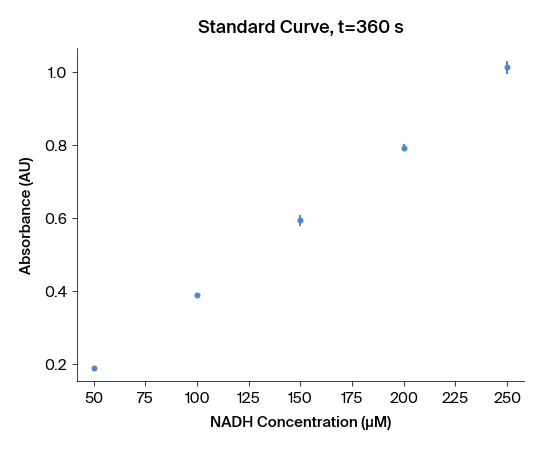

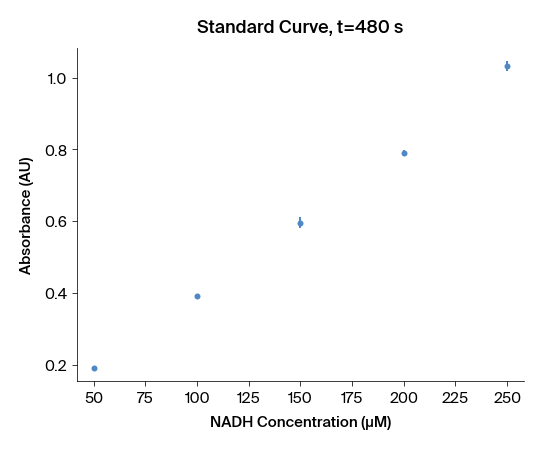

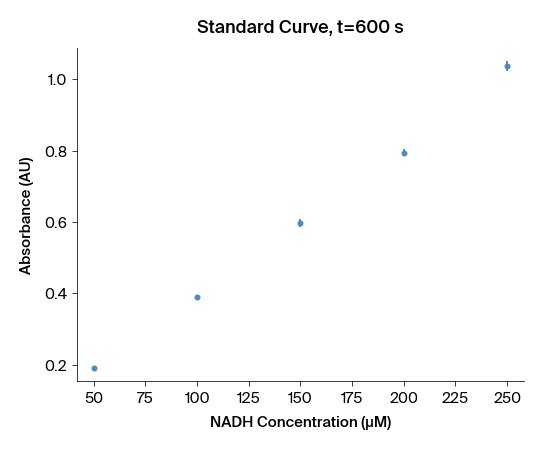

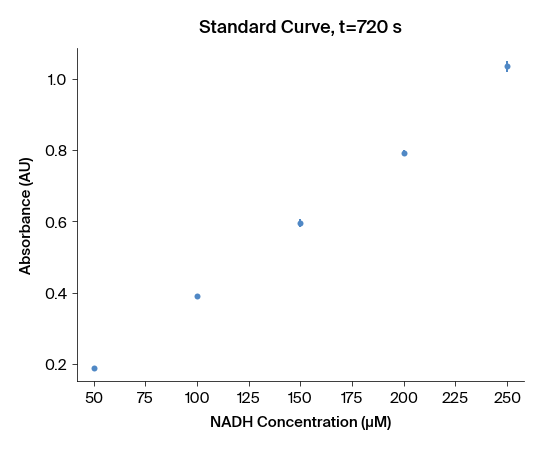

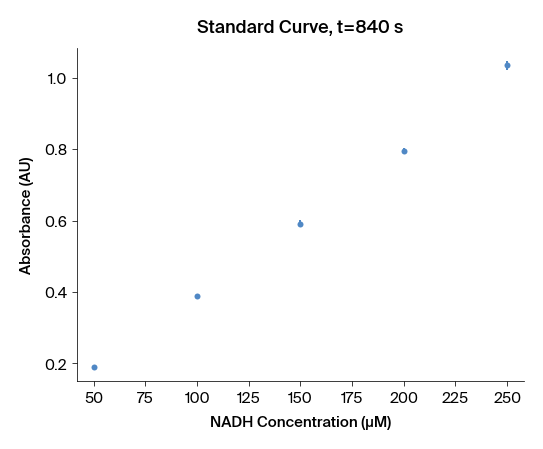

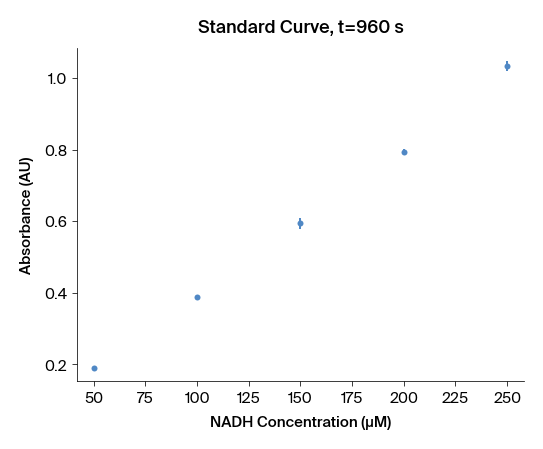

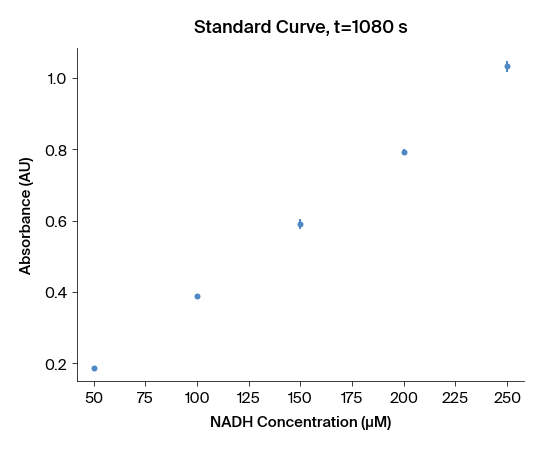

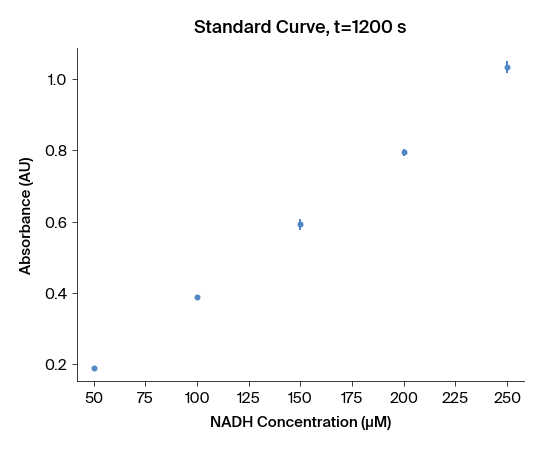

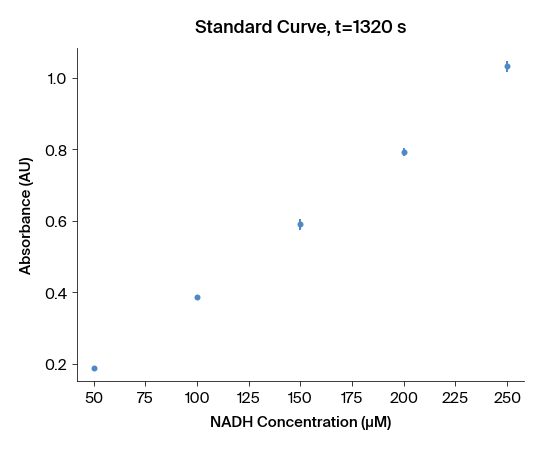

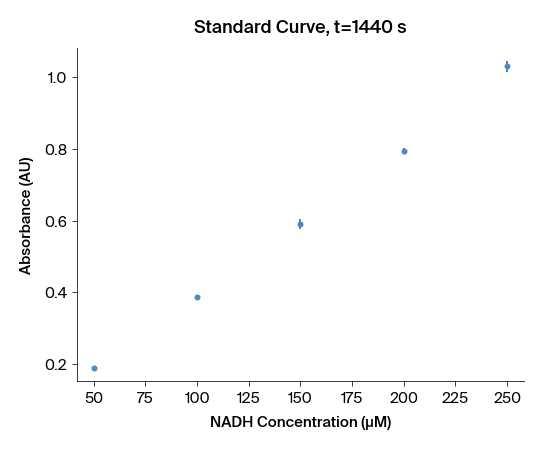

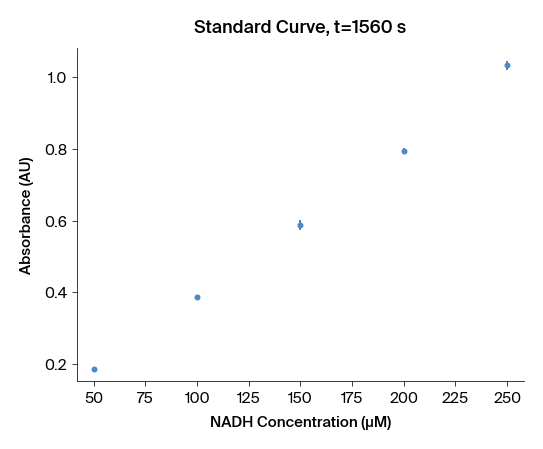

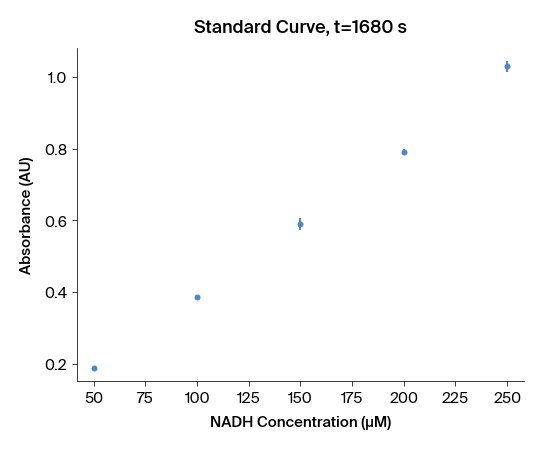

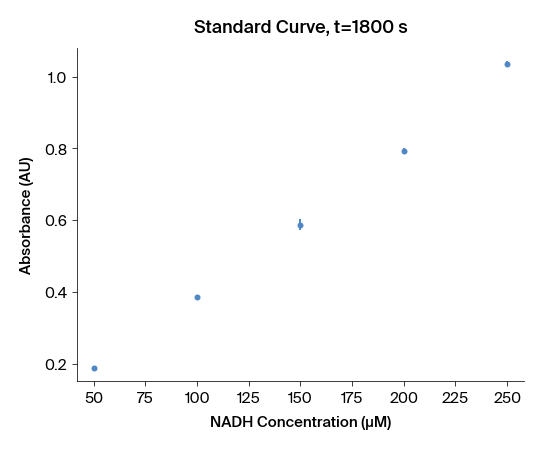

In [13]:
# Plot standard curves at each time point, which will be the basis for
# standard curve fitting and determining NADH concentrations in each well.

standards_output_dir = output_path + "/standard_curve_plots"
os.makedirs(standards_output_dir, exist_ok=True)

time_points = sample_data_collapsed["Cycle (seconds)"].unique()

for time_point in time_points:
    time_point_data = sample_data_collapsed[sample_data_collapsed["Cycle (seconds)"] == time_point]

    means = time_point_data[standard_columns].mean()
    std_devs = time_point_data[standard_columns].std()

    x_values = [int(col) for col in standard_columns]
    y_values = means.values
    y_errors = std_devs.values

    apc.mpl.setup()
    plt.figure(figsize=(8, 6))
    plt.errorbar(
        x_values,
        y_values,
        yerr=y_errors,
        fmt="o",
        capsize=5,
        label=f"Time Point {time_point}",
    )

    # User can update labels and title as needed.
    plt.xlabel("NADH Concentration (µM)")
    plt.ylabel("Absorbance (AU)")
    plt.title(f"Standard Curve, t={round(time_point)} s")

    file_path = os.path.join(standards_output_dir, f"standard_curve_timepoint_{round(time_point)}.png")
    plt.savefig(file_path, transparent=False)

    plt.show()

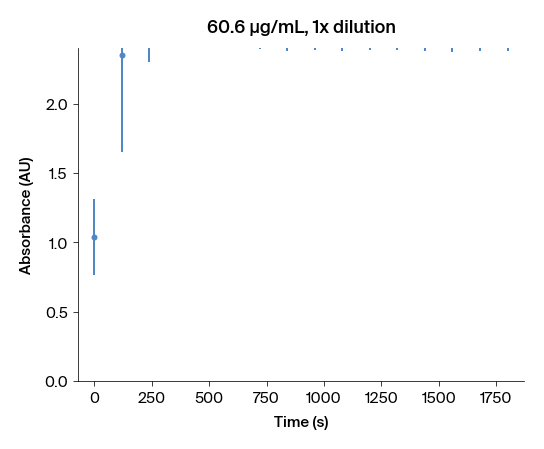

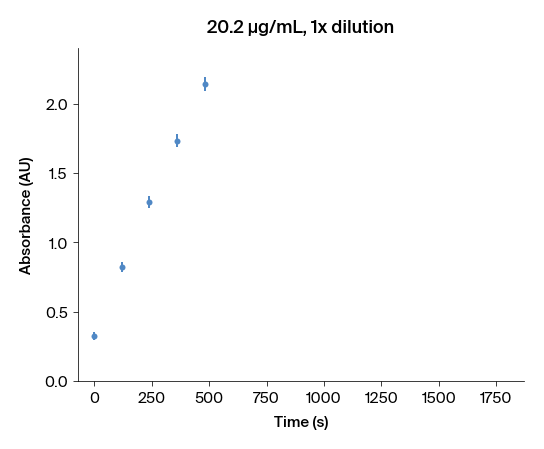

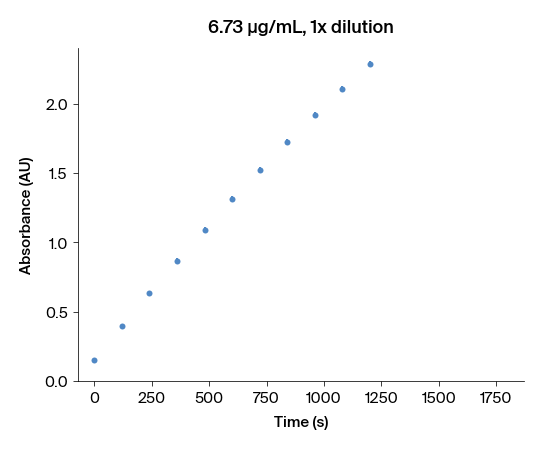

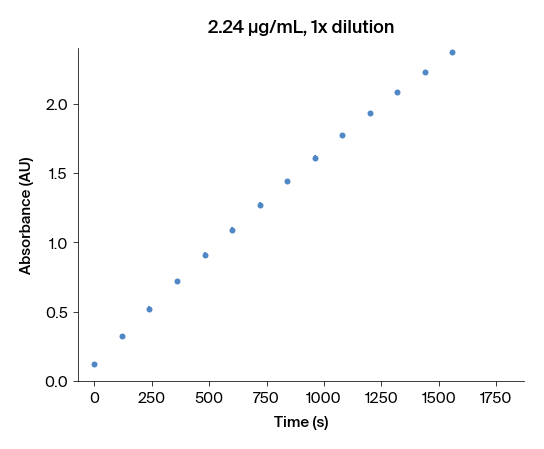

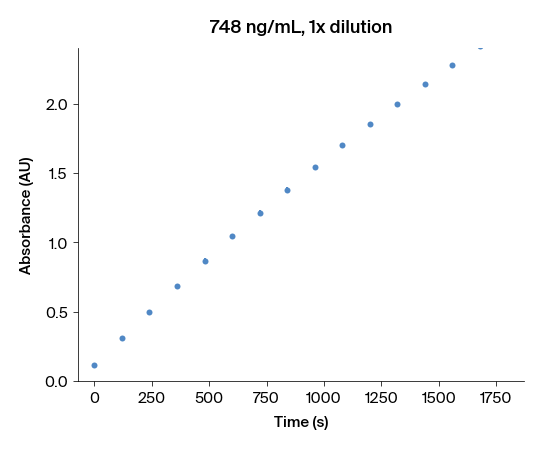

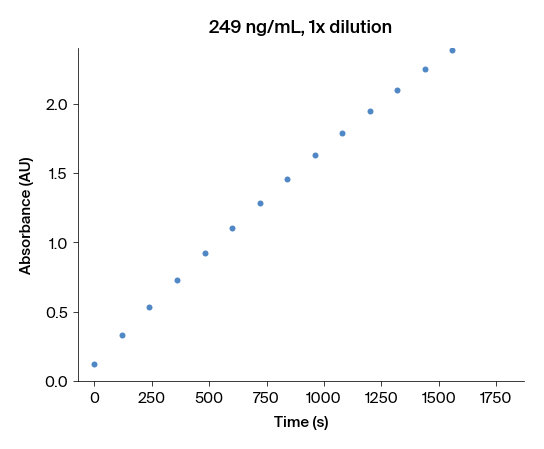

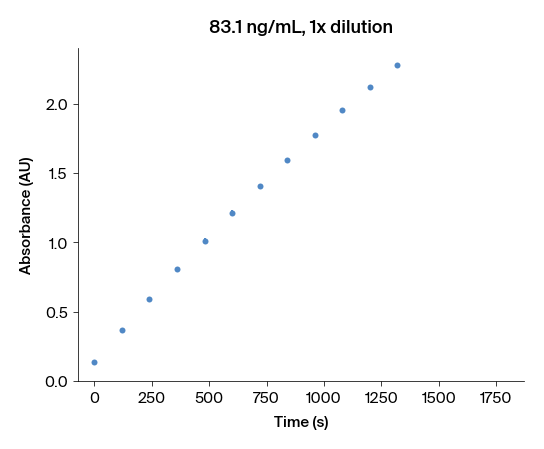

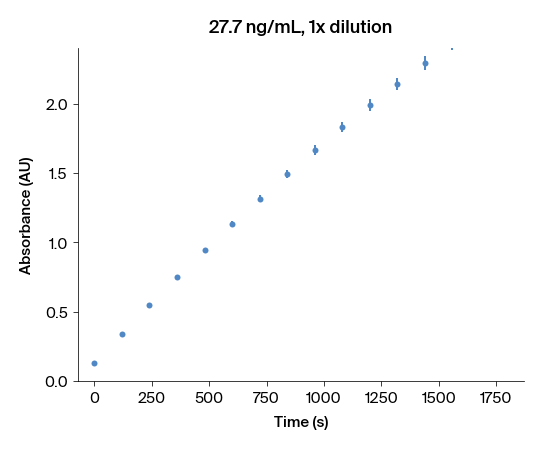

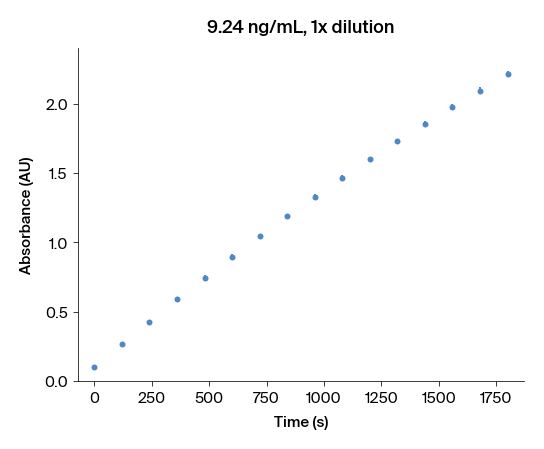

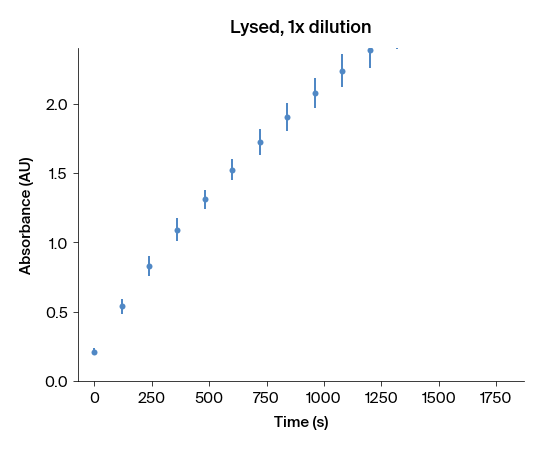

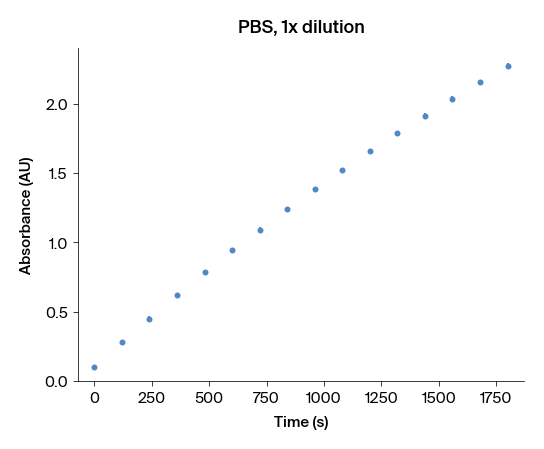

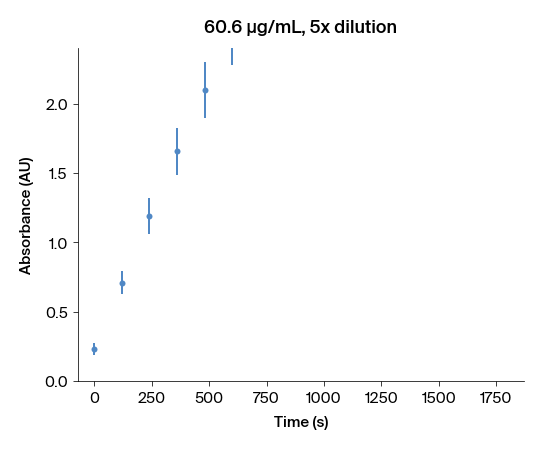

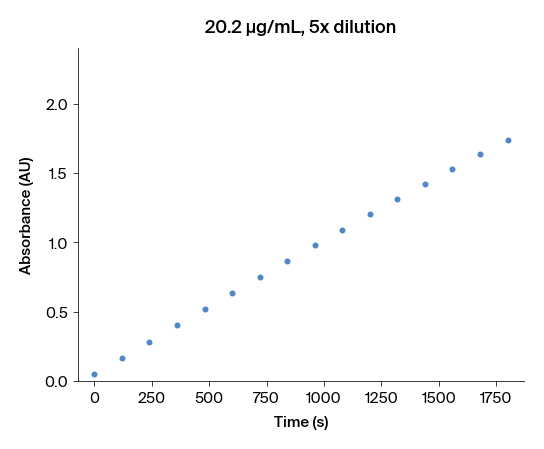

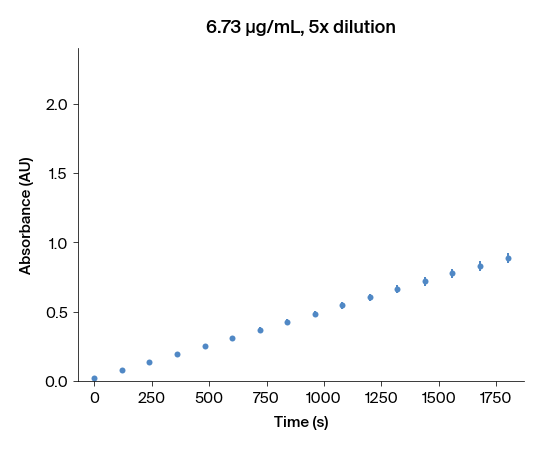

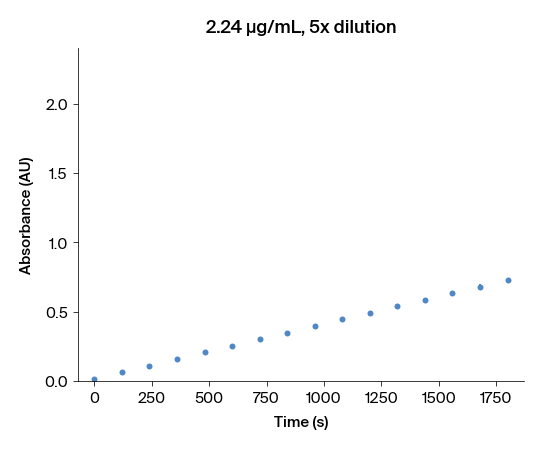

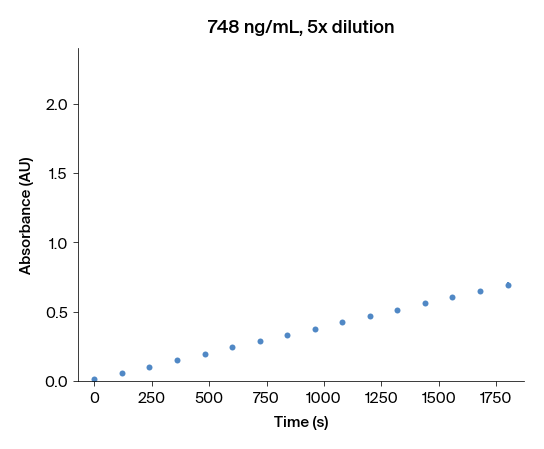

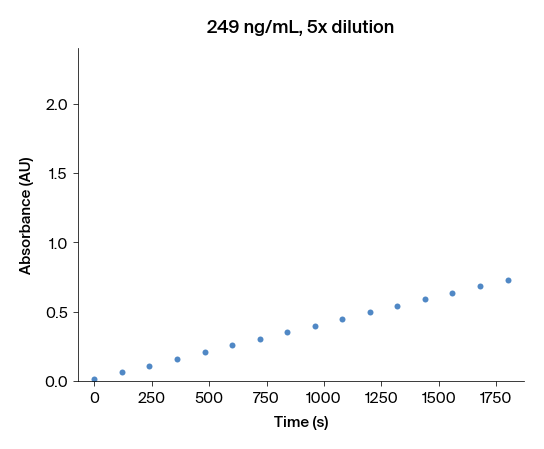

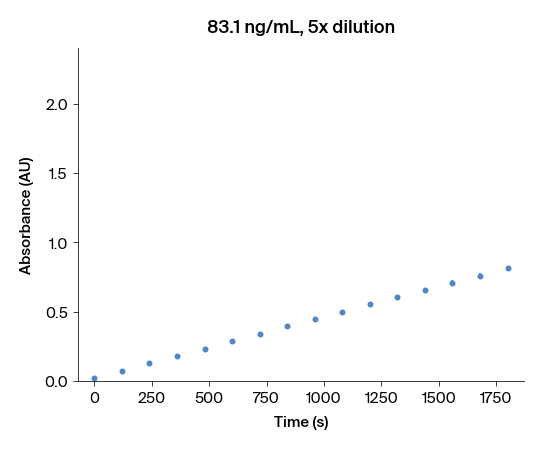

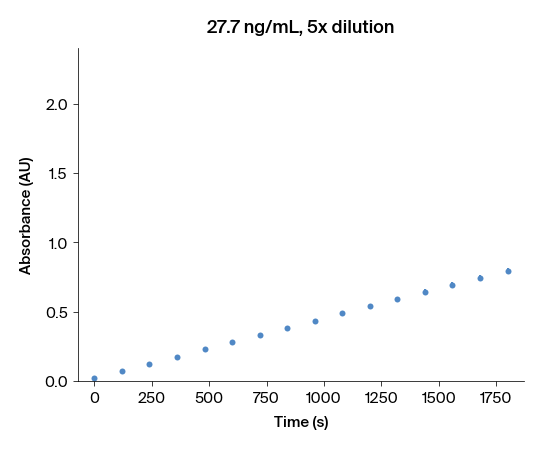

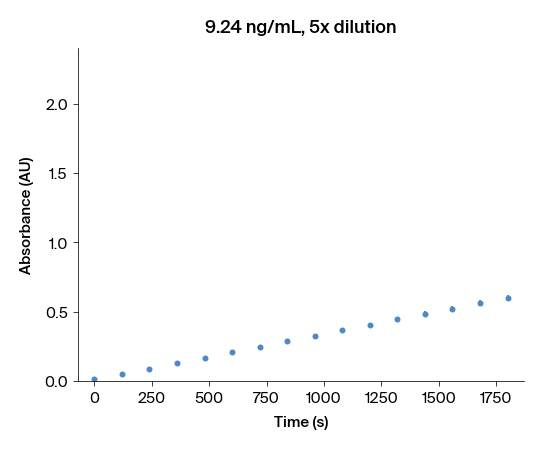

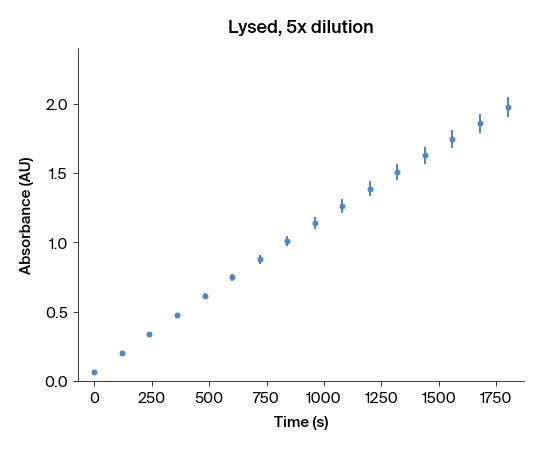

In [27]:
# Plot activity (signal vs. time) curves for each sample.
# Activity curves are used to select time points for enzyme activity quantification.

time_column = sample_data_collapsed.columns[0]
sample_columns = [
    col
    for col in sample_data_collapsed.columns
    if col not in standard_columns and col != time_column
]

samples_output_dir = output_path + "/activity_plots"
os.makedirs(samples_output_dir, exist_ok=True)


def sanitize_filename(text):
    """
    Convert a string of text into a valid file name by replacing
    or removing problematic ' ', '/', and ',' characters.

    Args:
        text: A string, such as a sample name, to be sanitized.

    Returns:
        str: The sanitized string, which can serve as a filename.
    """
    sanitized = text.replace(" ", "_").replace("/", "_").replace(",", "")
    return sanitized


for col in sample_columns:
    grouped = sample_data_collapsed.groupby(time_column)[col]
    means = grouped.mean()
    std_devs = grouped.std()

    x_values = means.index
    y_values = means.values
    y_errors = std_devs.values

    apc.mpl.setup()
    plt.figure(figsize=(8, 6))
    plt.errorbar(x_values, y_values, yerr=y_errors, fmt="o", capsize=5, label=col)

    # User can update labels and title as needed.
    plt.xlabel("Time (s)")
    plt.ylabel("Absorbance (AU)")
    plt.ylim(0, 2.4)
    plt.title(f"{col}")

    col_sanitized = sanitize_filename(col)
    file_path = os.path.join(samples_output_dir, f"activity_curve_{col_sanitized}.png")
    plt.savefig(file_path, transparent=False)

    plt.show()

In [15]:
# User must select time points t1 and t2 for analysis.
# Choose time points that fall in the linear range of the activity curves where possible.
t1 = 0  # s
t2 = 480  # s

if t1 is None or t2 is None:
    raise SystemExit("Please select time points for NADH and LDH quantification analysis")

In [16]:
# Curve fit will be performed on mean values of technical replicates,
# so a new dataframe containing the mean values will be generated.


def generate_mean_dataframe(collapsed_df, time_column):
    """
    Generate a mean dataframe with mean values for technical replicates at each time point.

    Args:
        collapsed_df: Dataframe containing labeled data with technical replicates.
        mean_df:
            A new dataframe with the same headers as collapsed_df,
            to be populated with mean values of technical replicates
        time_column: The name of the time column (i.e. 'Cycle (seconds)').

    Returns:
        pd.Dataframe:
            A populated dataframe containing the mean absorbance value
            for each sample at each time point.
    """
    mean_df = pd.DataFrame(columns=list(collapsed_df.columns))
    time_points = collapsed_df[time_column].unique()
    mean_df[time_column] = time_points

    for col in [c for c in collapsed_df.columns if c != time_column]:
        means = []

        for time_point in time_points:
            values = collapsed_df[collapsed_df[time_column] == time_point][col].dropna()
            mean_value = values.mean()
            means.append(mean_value)

        mean_df[col] = means

    return mean_df


sample_data_means = generate_mean_dataframe(sample_data_collapsed, time_column)
sample_data_means

,Cycle (seconds),"60.6 µg/mL, 1x dilution","20.2 µg/mL, 1x dilution","6.73 µg/mL, 1x dilution","2.24 µg/mL, 1x dilution","748 ng/mL, 1x dilution","249 ng/mL, 1x dilution","83.1 ng/mL, 1x dilution","27.7 ng/mL, 1x dilution","9.24 ng/mL, 1x dilution",...,"249 ng/mL, 5x dilution","83.1 ng/mL, 5x dilution","27.7 ng/mL, 5x dilution","9.24 ng/mL, 5x dilution","Lysed, 5x dilution",250,200,150,100,50
0,-0.0590,1.039667,0.324333,0.148333,0.122000,0.116333,0.124333,0.138333,0.127333,0.099333,...,0.015667,0.019333,0.019000,0.014000,0.066333,0.9280,0.7345,0.5510,0.3640,0.1810
1,119.9425,2.350500,0.822500,0.395833,0.325167,0.309500,0.330833,0.366833,0.339833,0.264500,...,0.064500,0.074500,0.072167,0.050167,0.202167,0.9685,0.7715,0.5820,0.3810,0.1875
2,239.8315,3.115833,1.291833,0.631833,0.522500,0.498833,0.530833,0.588500,0.544833,0.427167,...,0.111167,0.126500,0.122500,0.088167,0.338167,0.9890,0.7820,0.5865,0.3850,0.1885
3,359.7625,3.234833,1.733833,0.866167,0.718833,0.686167,0.729167,0.805167,0.747833,0.588500,...,0.160833,0.181500,0.175167,0.128500,0.477167,1.0115,0.7925,0.5930,0.3900,0.1900
4,479.9120,3.224333,2.142000,1.093000,0.909333,0.868667,0.920000,1.013000,0.944000,0.744333,...,0.208000,0.234333,0.228000,0.168000,0.613333,1.0325,0.7910,0.5960,0.3915,0.1905
5,599.8325,3.205833,2.514833,1.311167,1.092500,1.045500,1.106833,1.215167,1.134167,0.897167,...,0.257500,0.288833,0.280167,0.208500,0.748167,1.0375,0.7935,0.5970,0.3910,0.1910
6,719.7410,3.196333,2.847000,1.520333,1.270667,1.215667,1.285000,1.408000,1.316333,1.044000,...,0.304667,0.340333,0.331667,0.246667,0.879333,1.0350,0.7930,0.5955,0.3910,0.1900
7,839.8205,3.189833,3.126500,1.723833,1.443500,1.381500,1.459500,1.596167,1.494500,1.188167,...,0.352167,0.393500,0.383500,0.286500,1.010167,1.0355,0.7945,0.5915,0.3900,0.1895
8,959.7505,3.187167,3.350500,1.918833,1.612500,1.544500,1.627500,1.777167,1.666500,1.328500,...,0.400167,0.446833,0.436167,0.326500,1.137833,1.0340,0.7930,0.5940,0.3890,0.1895
9,1079.9095,3.178833,3.501167,2.105833,1.773500,1.700833,1.790500,1.951833,1.831500,1.465167,...,0.447833,0.499167,0.487500,0.365167,1.262833,1.0335,0.7925,0.5915,0.3885,0.1865


In [17]:
# This assay measures absorbance caused by NADH, a product of the LDH enzyme,
# so NADH concentrations at two time points are determined.
# Standard curve fits are determined at each of these time points.

time_column_list = sample_data_means[time_column].tolist()
time_column_list = [round(x) for x in time_column_list]

if t1 not in time_column_list or t2 not in time_column_list:
    raise SystemExit(
        "Time points not found. Please choose time points that are present in the dataset."
    )

else:
    t1loc = time_column_list.index(t1)
    t2loc = time_column_list.index(t2)

    row_t1 = sample_data_means.iloc[t1loc]
    row_t2 = sample_data_means.iloc[t2loc]

    if row_t1.isna().any() or row_t2.isna().any():
        print(
            """
            Time points successfully indexed for standard fitting.
            Warning: Data not available for all samples at these time points.
            """
        )
    else:
        print("Time points successfully indexed for standard fitting.")

Time points successfully indexed for standard fitting.


In [18]:
# Fit standard curve, t1

standard_ints = [int(x) for x in standard_columns]
x_values = np.array(standard_ints)
y_values_t1 = np.array([])

for col in standard_columns:
    value = sample_data_means.loc[t1loc, col]
    y_values_t1 = np.append(y_values_t1, value)


# Quadratic fit usually works best for absorbance data
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c


quadratic_params_t1, _ = curve_fit(quadratic_model, x_values, y_values_t1)
quadratic_predictions_t1 = quadratic_model(x_values, *quadratic_params_t1)
quadratic_r2_t1 = r2_score(y_values_t1, quadratic_predictions_t1)

print("t1 fit successful")
print(f"a, b, c: {quadratic_params_t1}")
print(f"R^2: {quadratic_r2_t1:.4f}")

t1 fit successful
a, b, c: [4.99999819e-07 3.57900006e-03 1.09999571e-03]
R^2: 1.0000


In [19]:
# Fit standard curve, t2

x_values = np.array(standard_ints)
y_values_t2 = np.array([])

for col in standard_columns:
    value = sample_data_means.loc[t2loc, col]
    y_values_t2 = np.append(y_values_t2, value)

quadratic_params_t2, _ = curve_fit(quadratic_model, x_values, y_values_t2)
quadratic_predictions_t2 = quadratic_model(x_values, *quadratic_params_t2)
quadratic_r2_t2 = r2_score(y_values_t2, quadratic_predictions_t2)

print("t2 fit successful")
print(f"a, b, c: {quadratic_params_t2}")
print(f"R^2: {quadratic_r2_t2:.4f}")

t2 fit successful
a, b, c: [2.04285649e-06 3.55414307e-03 1.09999848e-02]
R^2: 0.9994


In [20]:
# To streamline the output data, NADH and LDH concentrations are calculated in a new dataframe.
# Relevant absorbance data will be extracted from sample_data_collapsed,
# then transformed to NADH concentrations using standard fit,
# then used to calculate LDH concentration in activity units.


def extract_data_by_time(df, time_value, time_column):
    """
    Extract data for a given time point and create a dictionary of absorbance readings
    for each sample at the given time point.

    Args:
        df: Dataframe containing labeled data with technical replicates.
        time_value: The time point for which the dictionary should be generated.
        time_column (str):
            The name of the column containing time values. Typically 'Cycle (seconds)'.

    Returns:
        dict:
            A dictionary where keys are sample names (as strings) and values are lists of
            absorbance readings (as floats).
    """
    filtered_df = df[round(df[time_column]) == time_value]
    data_dict = {col: filtered_df[col].dropna().tolist() for col in sample_columns}

    return data_dict


def populate_dataframe_with_dict(df, data_dict, key_column, value_column):
    """
    Populate the results dataframe with absorbance values at a given time point.

    Args:
        df: The results dataframe to populate.
        data_dict:
            A dictionary with sample names as keys and lists of
            absorbance values as values.
        key_column:
            The string header of the column in df that will contain sample names.
        value_column:
            The string header of the column in df that will contain
            absorbance values at the relevant time point.

    Returns:
        pd.DataFrame:
            The populated dataframe relating sample names to their
            absorbance values at the relevant time point.
    """
    for sample_name, values in data_dict.items():
        for value in values:
            mask = (df[key_column] == sample_name) & (df[value_column].isna())
            if mask.any():
                df.loc[mask.idxmax(), value_column] = value
            else:
                new_row = {key_column: sample_name, value_column: value}
                df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    return df


t1_dict = extract_data_by_time(sample_data_collapsed, t1, time_column)
t2_dict = extract_data_by_time(sample_data_collapsed, t2, time_column)

sample_column = "Sample"
t1_abs_column = "Abs, t = " + str(t1)
t2_abs_column = "Abs, t = " + str(t2)
conc_columns = [sample_column, t1_abs_column, t2_abs_column]
NADH_LDH_concs = pd.DataFrame(columns=conc_columns)

NADH_LDH_concs = populate_dataframe_with_dict(NADH_LDH_concs, t1_dict, sample_column, t1_abs_column)
NADH_LDH_concs = populate_dataframe_with_dict(NADH_LDH_concs, t2_dict, sample_column, t2_abs_column)
NADH_LDH_concs

/var/folders/f0/d5_1_5d11vl9ywq_z1j0nnk40000gn/T/ipykernel_18694/3998069560.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


,Sample,"Abs, t = 0","Abs, t = 480"
0,"60.6 µg/mL, 1x dilution",0.725,2.296
1,"60.6 µg/mL, 1x dilution",1.234,3.68
2,"60.6 µg/mL, 1x dilution",1.160,3.697
3,"20.2 µg/mL, 1x dilution",0.353,2.19
4,"20.2 µg/mL, 1x dilution",0.330,2.142
...,...,...,...
58,"9.24 ng/mL, 5x dilution",0.023,0.17
59,"9.24 ng/mL, 5x dilution",0.008,0.172
60,"Lysed, 5x dilution",0.071,0.594
61,"Lysed, 5x dilution",0.068,0.609


In [21]:
# The curve fit parameters can be used to calculate the NADH concentrations
# at different time points, which can be used to determine enzyme activity.


def calculate_NADH_from_Abs(quadratic_params, df, abs_column):
    a, b, c = quadratic_params  # y = ax^2 + bx + c
    x_values = []
    y_values = df[abs_column]

    for y in y_values:
        adjusted_c = c - y

        discriminant = b**2 - 4 * a * adjusted_c

        if discriminant >= 0:
            root1 = (-b + np.sqrt(discriminant)) / (2 * a)
            root2 = (-b - np.sqrt(discriminant)) / (2 * a)

            # The correct NADH concentration should fall within the part of the curve
            # where absorbance increases with increasing NADH concentration.
            # For concave up fit, choose the non-negative (greater) root.
            # For concave down fit, choose the lesser positive root.
            if a > 0:
                root = max(root1, root2)
                x_values.append(root)
            else:
                root = min(root1, root2)
                x_values.append(root)

        else:
            # Handle cases where the discriminant is negative
            x_values.append(np.nan)

    x_values = np.array(x_values)
    return x_values


NADH_concs_t1 = calculate_NADH_from_Abs(quadratic_params_t1, NADH_LDH_concs, t1_abs_column)
NADH_concs_t2 = calculate_NADH_from_Abs(quadratic_params_t2, NADH_LDH_concs, t2_abs_column)

t1_NADH_column = "NADH, t = " + str(t1)
t2_NADH_column = "NADH, t = " + str(t2)

NADH_LDH_concs[t1_NADH_column] = NADH_concs_t1
NADH_LDH_concs[t2_NADH_column] = NADH_concs_t2
NADH_LDH_concs

,Sample,"Abs, t = 0","Abs, t = 480","NADH, t = 0","NADH, t = 480"
0,"60.6 µg/mL, 1x dilution",0.725,2.296,196.849706,499.502206
1,"60.6 µg/mL, 1x dilution",1.234,3.68,329.329695,727.831899
2,"60.6 µg/mL, 1x dilution",1.160,3.697,310.349689,730.434004
3,"20.2 µg/mL, 1x dilution",0.353,2.19,97.008841,480.423702
4,"20.2 µg/mL, 1x dilution",0.330,2.142,90.746722,471.695136
...,...,...,...,...,...
58,"9.24 ng/mL, 5x dilution",0.023,0.17,6.113807,43.641794
59,"9.24 ng/mL, 5x dilution",0.008,0.172,1.927395,44.177477
60,"Lysed, 5x dilution",0.071,0.594,19.477596,150.938921
61,"Lysed, 5x dilution",0.068,0.609,18.643813,154.529009


In [22]:
# Assay samples are sometimes diluted so that absorbance
# falls within range for accurate measurement.
# Extraction of dilution factors is necessary to calculate LDH enzyme concentrations.
# Sample names typically include the treatment (i.e. 5HT 3 µM)
# followed by the dilution factor (i.e. 1x dilution).
# A regular expression is used to identify this dilution factor.


def extract_dilution_factor(sample_name):
    """
    Extracts the dilution factor from a sample name string.

    Parameters:
        sample_name: The sample name to parse, as a string.

    Returns:
        int:
            The extracted dilution factor,
            or 1 if no dilution factor is found.
    """
    match = re.search(r"(\d+)x dilution", sample_name)
    if match:
        return int(match.group(1))
    else:
        return 1


dilution_factors = [extract_dilution_factor(sample) for sample in NADH_LDH_concs[sample_column]]
NADH_LDH_concs["dilution"] = dilution_factors
NADH_LDH_concs

,Sample,"Abs, t = 0","Abs, t = 480","NADH, t = 0","NADH, t = 480",dilution
0,"60.6 µg/mL, 1x dilution",0.725,2.296,196.849706,499.502206,1
1,"60.6 µg/mL, 1x dilution",1.234,3.68,329.329695,727.831899,1
2,"60.6 µg/mL, 1x dilution",1.160,3.697,310.349689,730.434004,1
3,"20.2 µg/mL, 1x dilution",0.353,2.19,97.008841,480.423702,1
4,"20.2 µg/mL, 1x dilution",0.330,2.142,90.746722,471.695136,1
...,...,...,...,...,...,...
58,"9.24 ng/mL, 5x dilution",0.023,0.17,6.113807,43.641794,5
59,"9.24 ng/mL, 5x dilution",0.008,0.172,1.927395,44.177477,5
60,"Lysed, 5x dilution",0.071,0.594,19.477596,150.938921,5
61,"Lysed, 5x dilution",0.068,0.609,18.643813,154.529009,5


In [23]:
# The change in NADH concentration over a known time interval can be used
# to calculate the LDH concentration in activity units.
# The extracted dilution factors will be used to determine the LDH
# concentration in the original supernatant sample.


def calculate_LDH_concs(df, t, V):
    LDH_concs = []

    for _index, row in df.iterrows():
        value_t2 = row[t2_NADH_column]
        value_t1 = row[t1_NADH_column]

        B = value_t2 - value_t1
        D = row["dilution"]

        if pd.isna(value_t2) or pd.isna(value_t1):
            LDH_concs.append(np.nan)

        else:
            conc = (B * D) / (t * V)
            if conc >= 0:
                LDH_concs.append(conc)

            else:
                LDH_concs.append(0)

    return LDH_concs


t = (t2 - t1) / 60  # Time interval in minutes.

LDH_concs = calculate_LDH_concs(NADH_LDH_concs, t, V)
NADH_LDH_concs["LDH"] = LDH_concs
NADH_LDH_concs.to_csv(output_filename + "_ldh_concs.csv", index=False)
NADH_LDH_concs

,Sample,"Abs, t = 0","Abs, t = 480","NADH, t = 0","NADH, t = 480",dilution,LDH
0,"60.6 µg/mL, 1x dilution",0.725,2.296,196.849706,499.502206,1,756.631252
1,"60.6 µg/mL, 1x dilution",1.234,3.68,329.329695,727.831899,1,996.255509
2,"60.6 µg/mL, 1x dilution",1.160,3.697,310.349689,730.434004,1,1050.210787
3,"20.2 µg/mL, 1x dilution",0.353,2.19,97.008841,480.423702,1,958.537152
4,"20.2 µg/mL, 1x dilution",0.330,2.142,90.746722,471.695136,1,952.371037
...,...,...,...,...,...,...,...
58,"9.24 ng/mL, 5x dilution",0.023,0.17,6.113807,43.641794,5,469.099834
59,"9.24 ng/mL, 5x dilution",0.008,0.172,1.927395,44.177477,5,528.126030
60,"Lysed, 5x dilution",0.071,0.594,19.477596,150.938921,5,1643.266562
61,"Lysed, 5x dilution",0.068,0.609,18.643813,154.529009,5,1698.564947


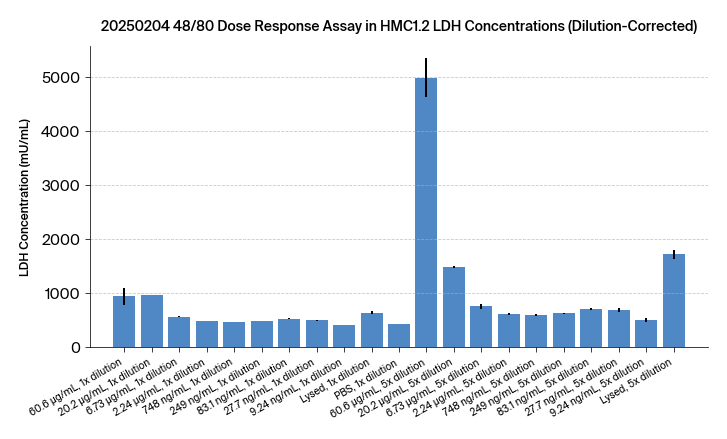

In [30]:
# Plot supernatant LDH concentrations for each sample.
# This plot visually represents the amount of cell death occurring
# in a given sample.
# Means and standard deviations of technical replicates are used to plot
# bars and error bars. Samples containing only NaN values are excluded.

grouped = (
    NADH_LDH_concs.groupby("Sample", sort=False)["LDH"]
    .agg(mean="mean", std="std", count="count")
    .reset_index()
)
grouped = grouped[grouped["count"] > 0]

samples = grouped["Sample"]
ldh_mean = grouped["mean"]
ldh_std = grouped["std"]

apc.mpl.setup()
plt.figure(figsize=(10, 6))
plt.bar(samples, ldh_mean, yerr=ldh_std)

# User can update labels and title as needed.
plt.ylabel("LDH Concentration (mU/mL)", fontsize=12)
plt.title(experiment_id + " LDH Concentrations (Dilution-Corrected)", fontsize=14)

# Customize x-axis labels for better readability
plt.xticks(rotation=30, ha="right", fontsize=10)

plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig(
    output_filename + "_LDH_concentrations.png",
    dpi=300,
    bbox_inches="tight",
    transparent=False,
)
plt.show()

In [26]:
# For samples with high LDH concentration, NADH readings may be off-scale.
# For samples where multiple dilutions have been analyzed, the sample with
# NADH readings within range (or closest to it) of the standard curve 
# (0 - 250 µM) will be extracted and plotted.

samples_in_range = []
sample_names_found = set()

# Identify samples that are on scale.
for _, row in NADH_LDH_concs.iterrows():
    if row.iloc[4] <= 250:
        sample_with_dilution = row.iloc[0]
        sample_name = sample_with_dilution.split(",")[0]

        if sample_with_dilution not in samples_in_range:
            samples_in_range.append(sample_with_dilution)
            sample_names_found.add(sample_name)

# Ensure all sample names are represented.
for _, row in NADH_LDH_concs.iterrows():
    sample_with_dilution = row.iloc[0]
    sample_name, dilution = sample_with_dilution.split(",")[0], sample_with_dilution.split(",")[-1]

    if sample_name not in sample_names_found and "5x dilution" in dilution:
        samples_in_range.append(sample_with_dilution)
        sample_names_found.add(sample_name)

# Keep 1x dilution if both dilutions are in range.
samples_dict = defaultdict(list)

for sample in samples_in_range:
    sample_name, dilution = sample.rsplit(", ", 1)
    samples_dict[sample_name].append(sample)

samples_in_range_filtered = []

for sample_name, entries in samples_dict.items():
    if len(entries) > 1:
        preferred_sample = next((s for s in entries if "1x dilution" in s), entries[0])
    else:
        preferred_sample = entries[0]
    
    samples_in_range_filtered.append(preferred_sample)

samples_in_range_filtered_ordered = []
seen_sample_names = set()

# Restore original order of entries.
for _, row in NADH_LDH_concs.iterrows():
    sample_with_dilution = row.iloc[0]
    sample_name = sample_with_dilution.split(",")[0]

    for full_sample in samples_in_range_filtered:
        if sample_name in full_sample and full_sample not in seen_sample_names:
            samples_in_range_filtered_ordered.append(full_sample)
            seen_sample_names.add(full_sample)
            break

samples_in_range_filtered = samples_in_range_filtered_ordered

NADH_LDH_concs_in_range = NADH_LDH_concs[NADH_LDH_concs["Sample"].isin(samples_in_range_filtered)].copy()
NADH_LDH_concs_in_range["Sample"] = NADH_LDH_concs_in_range["Sample"].apply(lambda x: x.split(",")[0] if "," in x else x)

NADH_LDH_concs_in_range["Sample"] = pd.Categorical(
    NADH_LDH_concs_in_range["Sample"],
    categories=[s.split(",")[0] for s in samples_in_range_filtered],  # Ordering based on sample names
    ordered=True
)

NADH_LDH_concs_in_range = NADH_LDH_concs_in_range.sort_values(by="Sample").reset_index(drop=True)
NADH_LDH_concs_in_range

,Sample,"Abs, t = 0","Abs, t = 480","NADH, t = 0","NADH, t = 480",dilution,LDH
0,60.6 µg/mL,0.192,1.867,52.947274,420.550160,5,4595.036070
1,60.6 µg/mL,0.276,2.195,76.002189,481.329685,5,5066.593700
2,60.6 µg/mL,0.230,2.234,63.394954,488.375613,5,5312.258236
3,20.2 µg/mL,0.058,0.521,15.863142,133.283764,5,1467.757775
4,20.2 µg/mL,0.048,0.519,13.080317,132.795686,5,1496.442101
5,20.2 µg/mL,0.049,0.515,13.358697,131.818816,5,1480.751489
6,6.73 µg/mL,0.024,0.241,6.392727,62.470118,5,700.967381
7,6.73 µg/mL,0.020,0.253,5.276916,65.614935,5,754.225236
8,6.73 µg/mL,0.021,0.264,5.555901,68.488425,5,786.656548
9,2.24 µg/mL,0.138,0.93,38.048659,228.548172,1,476.248782


/var/folders/f0/d5_1_5d11vl9ywq_z1j0nnk40000gn/T/ipykernel_18694/2324302988.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  NADH_LDH_concs_in_range.groupby("Sample", sort=False)["LDH"]


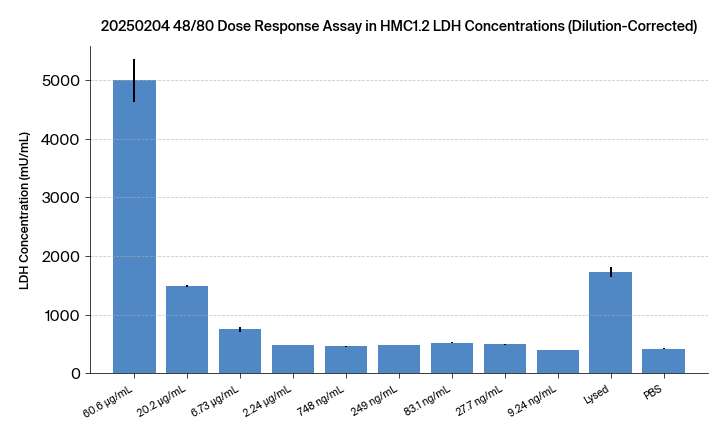

In [31]:
# Plot simplified graph

grouped = (
    NADH_LDH_concs_in_range.groupby("Sample", sort=False)["LDH"]
    .agg(mean="mean", std="std", count="count")
    .reset_index()
)
grouped = grouped[grouped["count"] > 0]

samples = grouped["Sample"]
ldh_mean = grouped["mean"]
ldh_std = grouped["std"]

apc.mpl.setup()
plt.figure(figsize=(10, 6))
plt.bar(samples, ldh_mean, yerr=ldh_std)

# User can update labels and title as needed.
plt.ylabel("LDH Concentration (mU/mL)", fontsize=12)
plt.title(experiment_id + " LDH Concentrations (Dilution-Corrected)", fontsize=14)

# Customize x-axis labels for better readability
plt.xticks(rotation=30, ha="right", fontsize=10)

plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig(
    output_filename + "_LDH_concentrations_in_range.png",
    dpi=300,
    bbox_inches="tight",
    transparent=False,
)
plt.show()

In [32]:
# One-way ANOVA is the most appropriate statistical test for this experiment.

LDH_concs = NADH_LDH_concs[["Sample", "LDH"]]
LDH_concs = LDH_concs.dropna(subset=["LDH"])
grouped_data = [group["LDH"].values for _, group in LDH_concs.groupby("Sample")]

anova_result = f_oneway(*grouped_data)
print(f"ANOVA result: F-value = {anova_result.statistic}, p-value = {anova_result.pvalue}")

ANOVA result: F-value = 365.23232045806077, p-value = 1.08275264554614e-40


In [34]:
# Tukey's HSD test is the most appropriate statistical test for post-hoc analysis.

tukey_result = pairwise_tukeyhsd(endog=LDH_concs["LDH"], groups=LDH_concs["Sample"], alpha=0.05)
print(tukey_result)

tukey_df = pd.DataFrame(
    data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0]
)
tukey_df.to_csv(output_filename + "_tukey_hsd_results.csv", index=False)

                     Multiple Comparison of Means - Tukey HSD, FWER=0.05                      
         group1                  group2          meandiff  p-adj    lower      upper    reject
----------------------------------------------------------------------------------------------
2.24 µg/mL, 1x dilution 2.24 µg/mL, 5x dilution   133.0812 0.9559  -147.3449   413.5074  False
2.24 µg/mL, 1x dilution 20.2 µg/mL, 1x dilution   480.4334    0.0   200.0073   760.8595   True
2.24 µg/mL, 1x dilution 20.2 µg/mL, 5x dilution  1005.8821    0.0    725.456  1286.3082   True
2.24 µg/mL, 1x dilution  249 ng/mL, 1x dilution     4.3562    1.0    -276.07   284.7823  False
2.24 µg/mL, 1x dilution  249 ng/mL, 5x dilution   145.4675 0.9073  -134.9587   425.8936  False
2.24 µg/mL, 1x dilution 27.7 ng/mL, 1x dilution      15.64    1.0  -264.7861   296.0662  False
2.24 µg/mL, 1x dilution 27.7 ng/mL, 5x dilution    199.879 0.4665   -80.5471   480.3052  False
2.24 µg/mL, 1x dilution 6.73 µg/mL, 1x dilution   

In [35]:
import sys

loaded_modules = {
    name: mod.__version__ for name, mod in sys.modules.items() if hasattr(mod, "__version__")
}
print(loaded_modules)

{'re': '2.2.1', 'ipaddress': '1.0', 'ipykernel._version': '6.29.4', 'json': '2.0.9', 'jupyter_client._version': '8.6.2', 'platform': '1.0.8', 'zmq.sugar.version': '26.0.3', 'zmq.sugar': '26.0.3', 'zmq': '26.0.3', 'logging': '0.5.1.2', 'traitlets._version': '5.14.3', 'traitlets': '5.14.3', 'jupyter_core.version': '5.7.2', 'jupyter_core': '5.7.2', 'zlib': '1.0', '_curses': b'2.2', 'socketserver': '0.4', 'argparse': '1.1', 'dateutil._version': '2.9.0.post0', 'dateutil': '2.9.0.post0', 'six': '1.16.0', '_decimal': '1.70', 'decimal': '1.70', 'platformdirs.version': '4.2.2', 'platformdirs': '4.2.2', '_csv': '1.0', 'csv': '1.0', 'jupyter_client': '8.6.2', 'ipykernel': '6.29.4', 'IPython.core.release': '8.26.0', 'executing.version': '2.0.1', 'executing': '2.0.1', 'pure_eval.version': '0.2.2', 'pure_eval': '0.2.2', 'stack_data.version': '0.6.3', 'stack_data': '0.6.3', 'pygments': '2.18.0', 'decorator': '5.1.1', 'wcwidth': '0.2.13', 'prompt_toolkit': '3.0.47', 'parso': '0.8.4', 'jedi': '0.19.1',

/var/folders/f0/d5_1_5d11vl9ywq_z1j0nnk40000gn/T/ipykernel_18694/3849240522.py:4: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.__version__.
  name: mod.__version__ for name, mod in sys.modules.items() if hasattr(mod, "__version__")
